In [1]:
import pandas as pd
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
import seaborn as sns
import h3

### 用維吉尼亞市的OHCA數據訓練MLP模型

In [2]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)

train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]
# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)
# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())
#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()
# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)
train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

def loss_function_with_regularization(model, output, target, l1_lambda=0.01):
    # 均方誤差損失
    mse_loss = nn.MSELoss()(output, target)
    
    # 計算 L1 和 L2 正則化項
    l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.parameters())
    
    # 總損失
    total_loss = mse_loss + l1_lambda * l1_penalty 
    
    return total_loss

class Regressor(nn.Module):
    """
    用於迴歸任務的神經網絡模型 Regressor。
    
    結構:
    - 兩層隱藏層，並使用 ReLU 激活函數
    - 最後一層為線性層，不使用激活函數（適用於迴歸）
    """
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super().__init__()
        # 定義三層全連接層
        self.fc1 = nn.Linear(input_size, hidden_size)     # 第一層：輸入層到隱藏層
        self.fc2 = nn.Linear(hidden_size, hidden_size)    # 第二層：隱藏層到隱藏層
        self.fc3 = nn.Linear(hidden_size, output_size)    # 第三層：隱藏層到輸出層

        # 初始化權重和偏置
        nn.init.normal_(self.fc1.weight, std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        # 前向傳播過程
        output = F.relu(self.fc1(input))  # 第一層 + ReLU 激活
        output = F.relu(self.fc2(output)) # 第二層 + ReLU 激活
        output = self.fc3(output)         # 第三層（不使用激活函數）
        return output
    
window_size = 1
seed = 123 #123
torch.manual_seed(seed)
np.random.seed(seed)

def train_reg(spatial_data, 
              s_net,
              s_net_optim, 
              window_size, iter_num=5000 , l2_lambda=1e-5):
    """
    訓練 s_net  網絡來預測 spatial_data 中的數據。
    
    參數:
    - spatial_data: numpy array，包含訓練數據
    - s_net: 神經網絡模型
    - s_net_optim: 優化器
    - window_size: 每次迭代的隨機取樣大小
    - iter_num: 訓練迭代次數
    
    返回:
    - loss_array: 每次迭代的損失值
    - t_fea_array, s_fea_array: 用於存儲特徵的暫時性陣列（目前未使用）
    """

    loss_array = []     # 儲存每次迭代的損失
    t_fea_array = []    # 預留用於儲存暫時性特徵的空列表
    s_fea_array = []    # 預留用於儲存暫時性特徵的空列表

    for _ in tqdm(range(iter_num)):
        
        # 隨機選擇一組數據索引
        h3_l7_id = np.random.choice(spatial_data.shape[0] - 1, window_size)


        # 提取目標變數（即輸入的最後一列數據）並轉為 Tensor
        ohca = spatial_data[h3_l7_id, -1].reshape(-1, 1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca))

        # p_pred 用於預測目標變數
        p_pred = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1]))).reshape(-1, 1)

        # 定義均方誤差損失
        mseloss = torch.nn.MSELoss(reduction='sum')
        loss = mseloss(p_pred, ohca)
        
        # 手動添加 L2 正則化項
        l2_reg = sum(p.pow(2.0).sum() for p in s_net.parameters())
        loss += l2_lambda * l2_reg

        # 清空前一次計算的梯度
        s_net_optim.zero_grad()
        
        
        # 計算損失的梯度
        loss.backward()

        # 更新神經網絡參數
        s_net_optim.step()
        
        # 儲存損失值
        loss_array.append(loss.detach().cpu().numpy())

    return loss_array, t_fea_array, s_fea_array

# 初始化模型和優化器
s_net = Regressor(input_size=spatial_data.shape[1] - 1, hidden_size=spatial_data.shape[1] * 2, output_size=1)
s_net_optim = optim.Adam(s_net.parameters(), lr=1e-4, weight_decay=1e-5) #lr=1e-4

iter_num=5000
# 執行訓練過程
loss_array, t_fea_array, s_fea_array = train_reg(train_spatial_data, s_net,
                                                 s_net_optim,
                                                 window_size, iter_num)


y_head_train = s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_train = train_spatial_data[:, -1].reshape(-1, 1)*ohca_reguli_inverse
y_head_test = s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_test = test_spatial_data[:, -1].reshape(-1, 1)*ohca_reguli_inverse

train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

100%|██████████| 5000/5000 [00:15<00:00, 325.92it/s]

MAE of train set=  1.370252211409879
R² of train set=  0.9731027424338505


### MLP with 宜興市 dataset

In [3]:
h3_l7_df_yixing = pd.read_csv('h3_l7_df_yixing.csv')

# 定義特徵欄位：排除 'ohca'，剩下的都是特徵
# h3_spatial_data 是您上面程式碼中已經 drop('id') 後的訓練數據
feature_cols = [col for col in h3_spatial_data.columns if col != 'ohca']

# 取得訓練集特徵的 Min 和 Range (Max - Min)
train_feat_min = h3_spatial_data[feature_cols].min()
train_feat_max = h3_spatial_data[feature_cols].max()
train_feat_range = train_feat_max - train_feat_min

# 【修正重點】取得 Target (OHCA) 的正確還原參數
# 您的舊代碼 ohca_reguli_inverse 算出來等於 Max，這會導致預測偏誤
# 正確的做法是分開記錄 Min 和 Range
train_ohca_min = h3_l7_df.ohca.min()
train_ohca_max = h3_l7_df.ohca.max()
train_ohca_range = train_ohca_max - train_ohca_min

# ---------------------------------------------------------
# 2. 預處理 h3_l7_df_yixing
# ---------------------------------------------------------
yixing_data = h3_l7_df_yixing.copy()

# 保留 ID 供最後輸出使用，但計算時要移除
yixing_ids = yixing_data['id']

# 確保只選取特徵欄位 (避免 yixing 裡混入了 ohca 或其他雜訊)
X_yixing = yixing_data[feature_cols]

# ---------------------------------------------------------
# 3. 正規化 (Normalization)
# ---------------------------------------------------------
# 必須使用訓練集的 Min 和 Range
X_yixing_norm = (X_yixing - train_feat_min) / train_feat_range

# ---------------------------------------------------------
# 4. 轉換為 PyTorch Tensor 並預測
# ---------------------------------------------------------
# 轉為 Numpy array 再轉 Tensor (float32 以符合 PyTorch 預設)
X_yixing_tensor = torch.FloatTensor(X_yixing_norm.values)

# 設定模型為評估模式 (Evaluation Mode) - 雖然這模型沒有 Dropout/Batchnorm，但這是好習慣
s_net.eval()

with torch.no_grad():  # 預測時不需要計算梯度，節省記憶體
    # 丟入模型進行預測
    y_pred_norm_tensor = s_net(X_yixing_tensor)

# 將結果轉回 Numpy array
y_pred_norm_np = y_pred_norm_tensor.detach().numpy()

# ---------------------------------------------------------
# 5. 反正規化 (Denormalization)
# ---------------------------------------------------------
# 使用正確的公式： 預測值 * Range + Min
y_pred_final = y_pred_norm_np * train_ohca_range + train_ohca_min

# ---------------------------------------------------------
# 6. 整理結果
# ---------------------------------------------------------
result_mlp_df = pd.DataFrame({
    'id': yixing_ids,
    'predicted_ohca': y_pred_final.flatten()  # flatten 將二維陣列 (N, 1) 攤平為一維
})

# 處理負數：將所有小於 0 的值設為 0
result_mlp_df['predicted_ohca'] = result_mlp_df['predicted_ohca'].clip(lower=0)

print("MLP 模型預測完成！前 5 筆預測結果：")
print(result_mlp_df.head(55))

# 簡單檢查預測範圍是否合理
print(f"\n預測值範圍: Min={result_mlp_df['predicted_ohca'].min():.2f}, Max={result_mlp_df['predicted_ohca'].max():.2f}")

MLP 模型預測完成！前 5 筆預測結果：
                 id  predicted_ohca
0   87309e000ffffff        1.734657
1   87309e001ffffff        7.909250
2   87309e002ffffff        3.180874
3   87309e003ffffff        0.246612
4   87309e004ffffff       79.685005
5   87309e005ffffff        0.549500
6   87309e006ffffff        0.000000
7   87309e008ffffff        0.434186
8   87309e009ffffff        0.662614
9   87309e00bffffff        0.000000
10  87309e00cffffff        0.691479
11  87309e00dffffff        0.380137
12  87309e00effffff        0.000000
13  87309e010ffffff        0.000000
14  87309e011ffffff       10.872398
15  87309e012ffffff       28.918428
16  87309e013ffffff        0.000000
17  87309e014ffffff      210.596024
18  87309e015ffffff       10.275386
19  87309e016ffffff       12.535102
20  87309e018ffffff        0.000000
21  87309e019ffffff        0.000000
22  87309e01bffffff        0.466296
23  87309e01cffffff        3.252993
24  87309e01dffffff        0.610687
25  87309e01effffff       16.055784
26  87

### 宜興市預測結果

繪圖數據範圍: Min=0.00, Max=950.67


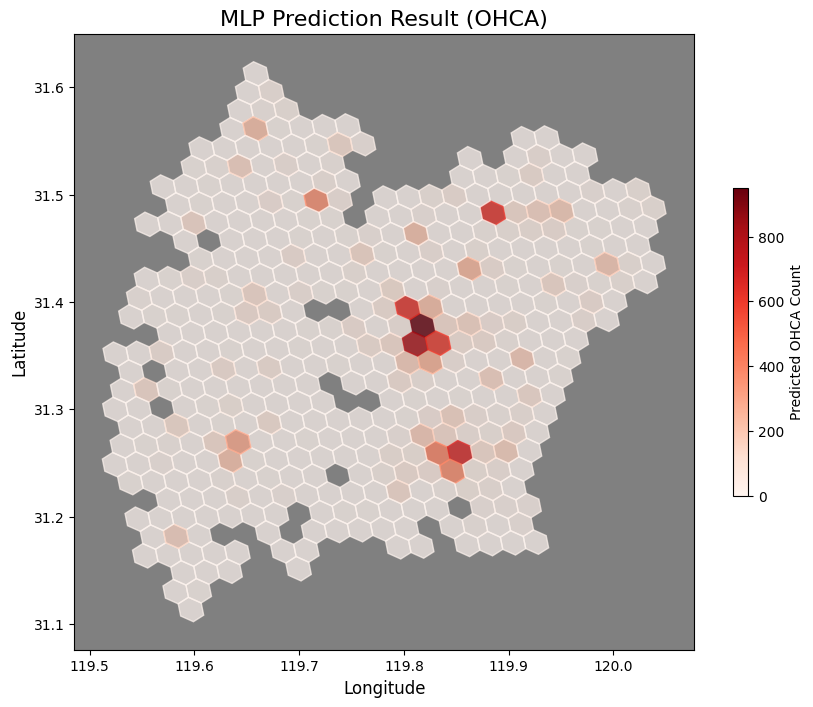

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Polygon
import h3

# ---------------------------------------------------------
# Step 1: 準備資料與設定參數
# ---------------------------------------------------------
# 使用我們剛剛預測並修正(clip)過的結果
plot_data = result_mlp_df[['id', 'predicted_ohca']]

# 設定顏色的最大最小值基準
# 這樣畫出來的顏色深淺才是根據這次預測結果的分布
vmin_val = plot_data['predicted_ohca'].min()
vmax_val = plot_data['predicted_ohca'].max()

print(f"繪圖數據範圍: Min={vmin_val:.2f}, Max={vmax_val:.2f}")

# 建立畫布
fig, ax = plt.subplots(figsize=(10, 8))

# 建立顏色映射物件 (Normalize)
norm = mcolors.Normalize(vmin=vmin_val, vmax=vmax_val)

# ---------------------------------------------------------
# Step 2: 繪製每個 H3 網格
# ---------------------------------------------------------
# 使用 iterrows 逐行讀取資料
for index, row in plot_data.iterrows():
    try:
        # 將 H3 索引轉換為多邊形邊界 (geo_json=True 確保格式為 (lng, lat))
        boundary = h3.h3_to_geo_boundary(row['id'], geo_json=True)
        polygon = Polygon(boundary)
        
        # 根據預測值 (predicted_ohca) 決定顏色
        # 注意這裡要用 row['predicted_ohca']
        val = row['predicted_ohca']
        color = plt.cm.Reds(norm(val))
        
        # 填色繪製
        ax.fill(*zip(*polygon.exterior.coords), color=color, alpha=0.7)
        
    except Exception as e:
        print(f"Error plotting H3 ID {row['id']}: {e}")
        continue

# ---------------------------------------------------------
# Step 3: 創建並顯示顏色條 (Colorbar)
# ---------------------------------------------------------
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([]) # 這是必要的，因為我們沒有直接傳入數據給 scalar mappable
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Predicted OHCA Count') # 設定標籤名稱

# ---------------------------------------------------------
# Step 4: 設定地圖細節與顯示
# ---------------------------------------------------------
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('MLP Prediction Result (OHCA)', fontsize=16) # 設定標題
ax.set_facecolor('grey') # 背景設為灰色，讓紅色區塊更明顯

# 自動調整視角範圍以包含所有畫出來的多邊形
ax.autoscale_view()

# 顯示地圖
plt.show()

# 若要存檔請取消註解
# fig.savefig('MLP_Prediction_Shenzhen.png', dpi=300)

### 宜興市可解釋分析

c:\Users\Yuan\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


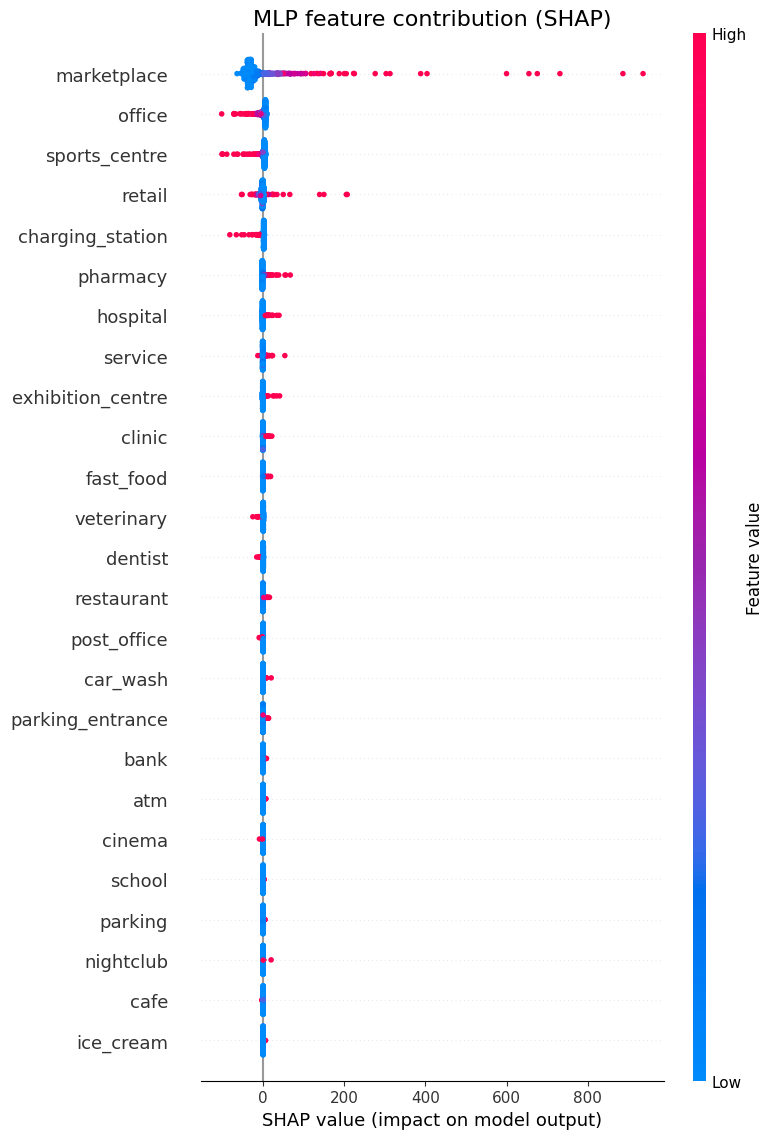

In [5]:
import shap

# 假設 `spatial_data` 包含背景數據，用於 SHAP 的解釋
background_data = X_yixing_tensor 
test_data = X_yixing_tensor  

# 建立 SHAP 解釋器，使用背景數據
explainer = shap.GradientExplainer(s_net, background_data)
shap_values_test = explainer.shap_values(test_data)* train_ohca_range + train_ohca_min
# Get the shap values from my test data
feature_names = X_yixing.columns

shap_col = shap_values_test.shape[0]
shap_row = shap_values_test.shape[1]
shap_values_test_2D = shap_values_test.reshape(shap_col,shap_row)

shap.summary_plot(shap_values_test_2D, 
                  test_data, 
                  feature_names, 
                  max_display=25,
                  show=False) 

# 2. 加入標題 (針對 s_net 命名為 MLP)
plt.title("MLP feature contribution (SHAP)", fontsize=16)

# 3. 顯示圖表
plt.tight_layout()
plt.show()